<a href="https://colab.research.google.com/github/ravidipu90/self-projects-/blob/main/ASSIGNMENT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Problem statements

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import accuracy_score

 1.Write a function to generate an input data matrix X of size NxD for regression. [0.5]

a) Input: Sample size N and a generator matrix S of size MxD

b) Working: First generate a random 2-D array of size NxM where each column has a standard
normal distribution and is independent of the other columns. Then multiply this with the
generator matrix S of size MxD to give an output matrix X of size NxD. The idea here is that
if the generator matrix S of size MxD is an identity matrix, then each column of X will
remain independent; otherwise we can introduce correlations in the matrix columns of X.

In [ ]:
def generate_data_matrix(N, S):
    """
    Generates an input data matrix X of size NxD for regression.

    Parameters:
    N (int): Sample size (number of rows).
    S (numpy array): Generator matrix of size MxD.

    Returns:
    X (numpy array): Output data matrix of size NxD.
    """

    M, D = S.shape # Get the size of the generator matrix S (MxD)
    Z = np.random.randn(N, M) # Step 1: Generate a random NxM matrix where each column has standard normal distribution
    X = np.dot(Z, S) # Step 2: Multiply the random matrix Z with the generator matrix S (NxM) * (MxD) -> (NxD)
    return X

2.Write a function to generate the target vector t of size Nx1: [0.5]

a) Input: Data matrix X of size NxD, weight vector w of size D+1 and noise variance σ

b) Working: Check for dimension mismatch between X and w, multiply X with w (sans one
element) and add the bias (the excluded element), then add zero-mean Gaussian noise
with variance σ.

In [ ]:
def generate_target_vector(X, w, sigma):
    """
    Generates the target vector t of size Nx1.

    Parameters:
    X (numpy array): Data matrix of size NxD.
    w (numpy array): Weight vector of size D+1 (D weights + 1 bias term).
    sigma (float): Noise variance for the Gaussian noise.

    Returns:
    t (numpy array): Target vector of size Nx1.
    """
    N, D = X.shape # Get the number of features (D) from X
    if len(w) != D + 1:             # Check if the dimensions of w match X (w should be of size D+1)
        raise ValueError("Dimension mismatch: w should be of size D+1.")
    # Separate the bias term (last element of w) and feature weights (first D elements of w)
    bias = w[-1]  # The last element of w is the bias
    weights = w[:-1]  # The first D elements of w are the feature weights
    linear_combination = np.dot(X, weights) # Step 1: Multiply X with the weight vector (without the bias term)

    t = linear_combination + bias  # Add the bias term
    noise = np.random.normal(0, np.sqrt(sigma), size=N) # Add Gaussian noise with zero mean and variance sigma
    t += noise # Add the noise to the target vector

    return t



3. Examine the behavior of the analytical solver based on pseudo-inverse (pinv) in numpy.linalg
package with respect to the size of the data matrix. Plot a graph of the time taken with respect to N
(use log scale for both axes), with D fixed to 10. Is there any strange behavior in time taken to solve
the problem above a particular value of N? What could be the reason for the same? [1]

Time for N=100, D=10: 0.0516 seconds
Time for N=278, D=10: 0.0005 seconds
Time for N=774, D=10: 0.0005 seconds
Time for N=2154, D=10: 0.0011 seconds
Time for N=5994, D=10: 0.0080 seconds
Time for N=16681, D=10: 0.0102 seconds
Time for N=46415, D=10: 0.0445 seconds
Time for N=129154, D=10: 0.0976 seconds
Time for N=359381, D=10: 0.2563 seconds
Time for N=1000000, D=10: 0.7470 seconds


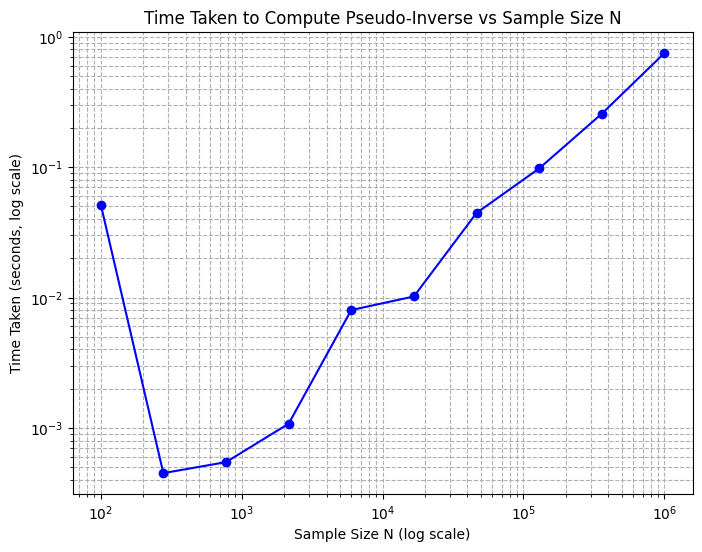

In [ ]:
def measure_pinv_time(N, D):
    """
    Measure the time taken to compute the pseudo-inverse for a data matrix of size N x D.

    Parameters:
    N (int): Number of samples (rows).
    D (int): Number of features (columns).

    Returns:
    float: Time taken to compute the pseudo-inverse.
    """
    X = np.random.randn(N, D)  # Generate a random data matrix of size N x D
    start_time = time.time()   # Measure the time taken to compute the pseudo-inverse
    np.linalg.pinv(X)
    end_time = time.time()
    return end_time - start_time

# Define parameters
D = 10  # Number of features
N_values = np.logspace(2, 6, num=10, dtype=int)  # Sample sizes from 10^2 to 10^6
times = []

# Measure time taken for each N
for N in N_values:
    t = measure_pinv_time(N, D)
    times.append(t)
    print(f"Time for N={N}, D={D}: {t:.4f} seconds")

# Plot the results on a log-log scale
plt.figure(figsize=(8, 6))
plt.loglog(N_values, times, marker='o', linestyle='-', color='b')
plt.xlabel("Sample Size N (log scale)")
plt.ylabel("Time Taken (seconds, log scale)")
plt.title("Time Taken to Compute Pseudo-Inverse vs Sample Size N")
plt.grid(True, which="both", ls="--")
plt.show()


4.Write a function to calculate the normalized root mean squared error (NRMSE) between a target  vector t and a predicted vector y. [0.5]

In [ ]:
def calculate_nrmse(t, y):
    """
    Calculate the Normalized Root Mean Squared Error (NRMSE) between the target vector t and the predicted vector y.

    Parameters:
    t (numpy.ndarray): Target vector of size N.
    y (numpy.ndarray): Predicted vector of size N.

    Returns:
    float: NRMSE value.
    """

    rmse = np.sqrt(np.mean((t - y) ** 2))    # Compute the RMSE
    range_t = np.max(t) - np.min(t)  # Compute the range of the target vector t
    if range_t == 0:                 # Calculate the NRMSE
        raise ValueError("Range of target vector t is zero, cannot compute NRMSE.")

    nrmse = rmse / range_t

    return nrmse



5.Write a function to calculate gradient of mean squared error (MSE) with respect to weights of
linear regression. Figure out what should be the inputs and outputs. [0.5]

In [ ]:
def calculate_mse_gradient(X, y, w, b):
    """
    Calculate the gradient of Mean Squared Error (MSE) with respect to weights and bias.

    Parameters:
    X : np.ndarray
        Input features (N x M)
    y : np.ndarray
        Actual target values (N x 1)
    w : np.ndarray
        Weights (M x 1)
    b : float
        Bias term

    Returns:
    gradient : np.ndarray
        Gradient with respect to weights (M x 1)
    bias_gradient : float
        Gradient with respect to bias
    """
    N = X.shape[0]  # Number of samples
    predictions = X.dot(w) + b  # Linear model predictions
    errors = predictions - y  # Errors

    # Calculate gradients
    gradient = (2 / N) * X.T.dot(errors)  # Gradient with respect to weights
    bias_gradient = (2 / N) * np.sum(errors)  # Gradient with respect to bias

    return gradient, bias_gradient

6.Write a function to calculate gradient of L2 norm of weights with respect to weights. [0.5]

In [ ]:
def gradient_l2_norm(w, include_bias=True):
    """
    Calculate the gradient of the L2 norm of weights with respect to the weights.

    Parameters:
    w (numpy.ndarray): Weight vector of size D.
    include_bias (bool): Whether to include the bias term in the gradient calculation.

    Returns:
    numpy.ndarray: Gradient of the L2 norm with respect to weights of size D or D-1.
    """
    if include_bias:
        return 2 * w  # Include all weights, including bias
    else:
        return 2 * w[:-1]  # Exclude bias term



7.Write a function to calculate gradient of L1 norm of weights with respect to weights. [0.5]

In [ ]:
def gradient_l1_norm(w, include_bias=True):
    """
    Calculate the gradient of the L1 norm of weights with respect to the weights.

    Parameters:
    w (numpy.ndarray): Weight vector of size D.
    include_bias (bool): Whether to include the bias term in the gradient calculation.

    Returns:
    numpy.ndarray: Sub-gradient of the L1 norm with respect to weights of size D or D-1.
    """
    if include_bias:
        # Include all weights
        gradient = np.zeros_like(w)
        gradient[w > 0] = 1
        gradient[w < 0] = -1
    else:
        # Exclude bias term
        gradient = np.sign(w[:-1])  # Compute sign of all weights except the last

    return gradient


8.Write a function to perform gradient descent on MSE + λ1 L1 + λ2 L2 for linear regression. Use an
appropriate stopping criterion. [1]

In [ ]:
def gradient_descent(X, t, lambda_1=0.01, lambda_2=0.01, learning_rate=0.001, max_iter=1000, tol=1e-6):
     """
     Perform gradient descent on MSE + λ₁L₁ + λ₂L₂ for linear regression.

     Parameters:
     X (numpy.ndarray): Data matrix.
     t (numpy.ndarray): Target vector.
     lambda_1 (float): L1 regularization parameter.
     lambda_2 (float): L2 regularization parameter.
     learning_rate (float): Learning rate for gradient descent.
     max_iter (int): Maximum number of iterations.
     tol (float): Tolerance for stopping criterion.

     Returns:
     numpy.ndarray: Optimized weight vector including bias term.
     """
     N, D = X.shape

     w = np.zeros(D + 1)   # Initialize weights including bias term

     for _ in range(max_iter):
         grad_mse = gradient_mse(X, t, w)
         grad_l1 = lambda_1 * np.append(gradient_l1_norm(w), [0])   # Append zero for bias term
         grad_l2 = lambda_2 * np.append(gradient_l2_norm(w), [0])   # Append zero for bias term

         gradient = grad_mse + grad_l1 + grad_l2

         new_w = w - learning_rate * gradient

         if np.linalg.norm(new_w - w) < tol:
             break

         w = new_w

     return w

9.Examine the impact of σ on the NRMSE for linear regression using gradient descent. Average the results of the following experiment run five times for each value of σ where G is an identity matrix. Generate a random data matrix X and target vector t with noise variance σ, and split it into training
and validation sub-matrices and sub-vectors. Train using gradient descent on training subset, and test on the validation subset. Plot average NRMSE on validation subset for five runs versus σ.

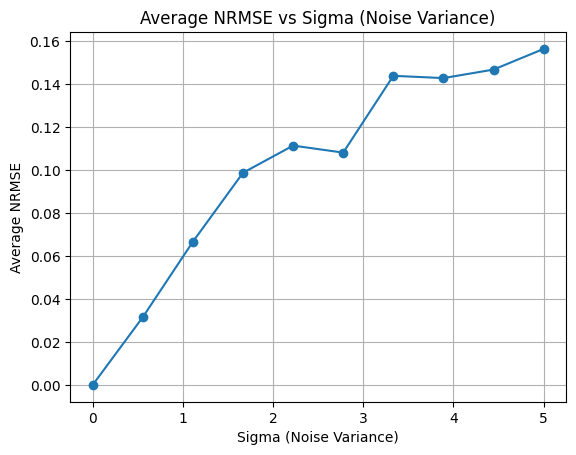

In [ ]:
# Normalized RMSE function
def nrmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) / (np.max(y_true) - np.min(y_true))

# Parameters
n_samples = 1000
n_features = 10
sigma_values = np.linspace(0, 5, 10)  # Different values of sigma
n_runs = 5  # Number of runs for averaging

# Storing results
avg_nrmse = []

for sigma in sigma_values:
    run_nrmse = []
    for run in range(n_runs):
        # Generate random data
        X = np.random.randn(n_samples, n_features)
        true_coefficients = np.random.randn(n_features)
        noise = np.random.normal(0, sigma, n_samples)

        # Generate target values with noise
        t = X @ true_coefficients + noise

        # Split into training and validation sets
        X_train, X_val, t_train, t_val = train_test_split(X, t, test_size=0.2)

        # Train using gradient descent (SGDRegressor for linear regression)
        model = SGDRegressor(max_iter=1000, tol=1e-3)
        model.fit(X_train, t_train)

        # Predict on validation set
        t_pred = model.predict(X_val)

        # Calculate NRMSE
        error = nrmse(t_val, t_pred)
        run_nrmse.append(error)

    # Average NRMSE for this sigma
    avg_nrmse.append(np.mean(run_nrmse))

# Plotting the results
plt.plot(sigma_values, avg_nrmse, marker='o')
plt.xlabel('Sigma (Noise Variance)')
plt.ylabel('Average NRMSE')
plt.title('Average NRMSE vs Sigma (Noise Variance)')
plt.grid(True)
plt.show()


Comment on Results:

* As σ (noise variance) increases, we expect the NRMSE to increase since the
  model will find it harder to fit the noisy data accurately.

* At very low σ, the NRMSE should be minimal since the model can capture the
  underlying linear relationship with little interference from noise.



* At higher values of σ, the increased noise introduces more variability, and
  the model will have a harder time minimizing the error, leading to a higher NRMSE.






















10.Examine the impact of N and λ2 on the NRMSE for linear regression using gradient descent. Create lists of N and λ2 values (use log scale, 5 each, 25 pairs). Average the results of the following experiment run five times for combination of N and λ2 value pair for a fixed generator matrix G and
noise variance σ. Comment on the results. [1.5]

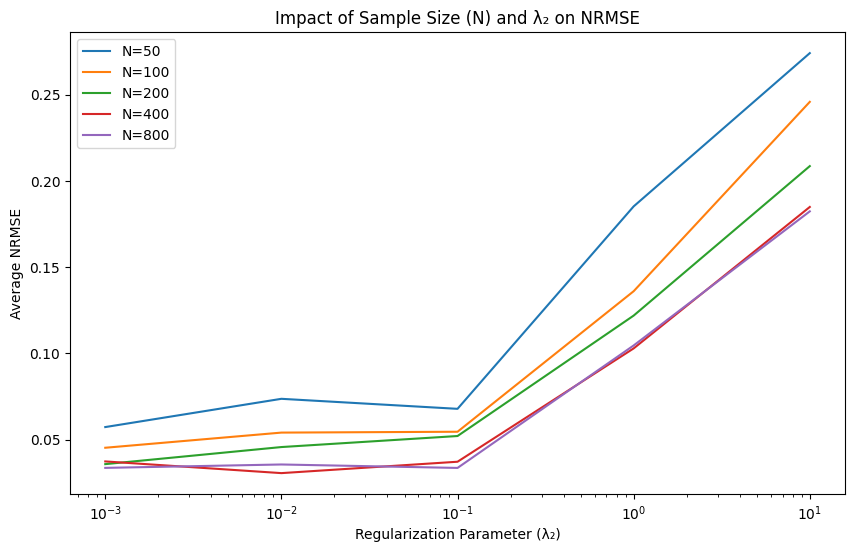

In [ ]:
def generate_data(N, D, sigma):
    X = np.random.randn(N, D)
    w_true = np.random.randn(D + 1)
    t = X @ w_true[:-1] + w_true[-1] + np.random.normal(0, sigma, N)
    return X, t

def split_data(X, t, train_ratio=0.8):
    N = len(t)
    train_size = int(N * train_ratio)
    indices = np.random.permutation(N)
    train_idx, val_idx = indices[:train_size], indices[train_size:]
    return X[train_idx], t[train_idx], X[val_idx], t[val_idx]

def gradient_descent(X, t, lambda_2, alpha=0.01, iterations=1000):
    N, D = X.shape
    X = np.hstack([X, np.ones((N, 1))])  # Add a bias term (column of ones)
    w = np.zeros(D + 1)  # Initialize weights including bias

    for _ in range(iterations):
        # Compute predictions
        y_pred = X @ w

        # Compute gradient
        gradient = -(2 / N) * X.T @ (t - y_pred) + 2 * lambda_2 * np.hstack([w[:-1], 0])  # No regularization for bias

        # Update weights
        w = w - alpha * gradient

    return w

def calculate_nrmse(t_true, t_pred):
    rmse = np.sqrt(np.mean((t_true - t_pred) ** 2))
    nrmse = rmse / (np.max(t_true) - np.min(t_true))
    return nrmse

def run_experiment(N_values, lambda_2_values, D=10, sigma=0.5):
    nrmse_results = np.zeros((len(N_values), len(lambda_2_values)))

    for i, N in enumerate(N_values):
        for j, lambda_2 in enumerate(lambda_2_values):
            nrmse_list = []
            for _ in range(5):  # Run experiment 5 times
                X, t = generate_data(N, D, sigma)
                X_train, t_train, X_val, t_val = split_data(X, t)

                # Train model using gradient descent
                w_estimated = gradient_descent(X_train, t_train, lambda_2=lambda_2)

                # Predict on validation set
                y_pred = X_val @ w_estimated[:-1] + w_estimated[-1]
                nrmse = calculate_nrmse(t_val, y_pred)
                nrmse_list.append(nrmse)

            avg_nrmse = np.mean(nrmse_list)
            nrmse_results[i][j] = avg_nrmse

    plt.figure(figsize=(10, 6))
    for i, N in enumerate(N_values):
        plt.plot(lambda_2_values, nrmse_results[i], label=f'N={N}')

    plt.xscale('log')
    plt.xlabel('Regularization Parameter (λ₂)')
    plt.ylabel('Average NRMSE')
    plt.title('Impact of Sample Size (N) and λ₂ on NRMSE')
    plt.legend()
    plt.show()

# Example:
N_values = [50, 100, 200, 400, 800]  # Sample sizes
lambda_2_values = np.logspace(-3, 1, 5)  # λ₂ values in log scale
run_experiment(N_values, lambda_2_values)




Observations

As N increases, you may observe that NRMSE decreases due to more data proThe effect of λ2 may show that higher regularization can help reduce overfitting but might increase bias.

The plot should reveal trends where different combinations of N and λ2 impact model performance differently.

11. Examine the impact of λ1 on variable elimination. Generate a single data matrix X and plot weights versus 1/λ1. Comment on the results. Introduce correlations in the columns of X and repeat the experiment. Are the results different? Comment on the results. [1]

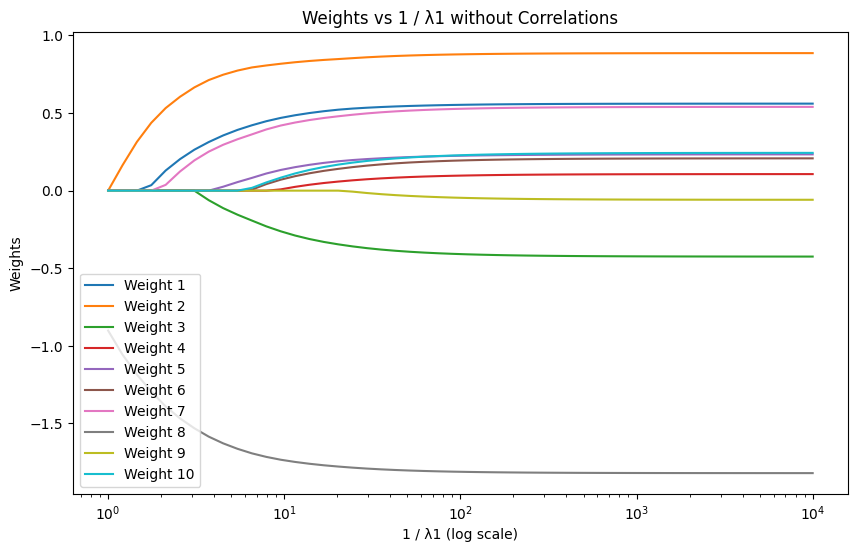

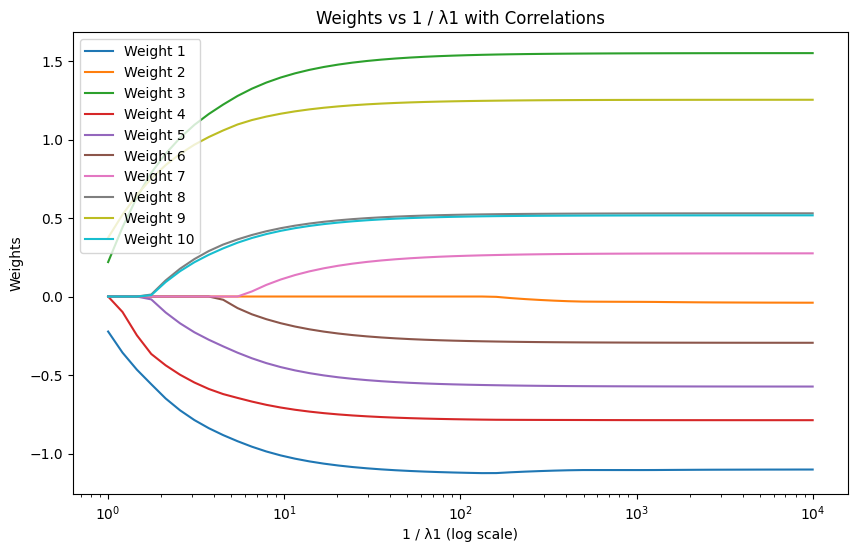

In [ ]:
# Function to generate data
def generate_data(N, D, sigma=0.1, correlated=False):
    np.random.seed(0)
    X = np.random.randn(N, D)

    # Introduce correlations if required
    if correlated:
        X[:, 1] = 0.8 * X[:, 0] + 0.2 * np.random.randn(N)  # Correlating column 1 with column 0

    # Generate true weights and target
    w_true = np.random.randn(D)
    y = X @ w_true + np.random.normal(0, sigma, N)

    return X, y, w_true

# Function to run Lasso for different values of λ1
def run_lasso_experiment(X, y, lambda1_values):
    coefficients = []
    for lam in lambda1_values:
        lasso = Lasso(alpha=lam, fit_intercept=False)
        lasso.fit(X, y)
        coefficients.append(lasso.coef_)
    return np.array(coefficients)

# Parameters
N = 100  # Number of samples
D = 10   # Number of features
lambda1_values = np.logspace(-4, 0, 50)  # Range of λ1 values
sigma = 0.1  # Noise level

# Generate data without correlations
X, y, w_true = generate_data(N, D, sigma)

# Run Lasso regression for different λ1 values
coefficients = run_lasso_experiment(X, y, lambda1_values)

# Plot the results for independent features
plt.figure(figsize=(10, 6))
for i in range(D):
    plt.plot(1 / lambda1_values, coefficients[:, i], label=f'Weight {i+1}')
plt.xscale('log')
plt.xlabel('1 / λ1 (log scale)')
plt.ylabel('Weights')
plt.title('Weights vs 1 / λ1 without Correlations')
plt.legend()
plt.show()

# Now introduce correlations and repeat the experiment
X_corr, y_corr, _ = generate_data(N, D, sigma, correlated=True)
coefficients_corr = run_lasso_experiment(X_corr, y_corr, lambda1_values)

# Plot the results with correlated features
plt.figure(figsize=(10, 6))
for i in range(D):
    plt.plot(1 / lambda1_values, coefficients_corr[:, i], label=f'Weight {i+1}')
plt.xscale('log')
plt.xlabel('1 / λ1 (log scale)')
plt.ylabel('Weights')
plt.title('Weights vs 1 / λ1 with Correlations')
plt.legend()
plt.show()


Without Correlations:

As λ1 increases (or 1/λ1 decreases), Lasso progressively shrinks the weights of less important features to zero. The most important features (those with the largest true weights) tend to have non-zero coefficients for a longer range of λ1.

With Correlations:

When correlations are introduced, Lasso tends to select one feature from the correlated group and eliminate the others. This is because correlated features provide redundant information, and Lasso tries to minimize the number of active features.

Comments:

Impact of λ1 on Variable Elimination:

Lasso performs variable elimination by shrinking the coefficients of less important features to zero as λ1 increases. This makes it an effective tool for feature selection.

Effect of Correlations:

When there are correlated features, Lasso arbitrarily selects one feature from the correlated set while shrinking the others to zero. This can result in instability in feature selection if the data has highly correlated variables.
In the correlated case, feature elimination is more aggressive for the redundant features, but the resulting model might lose some interpretability because it’s hard to predict which feature from the correlated set will be selected.

**12. Show the grouping effect of elastic net on correlated columns of X. [1]**

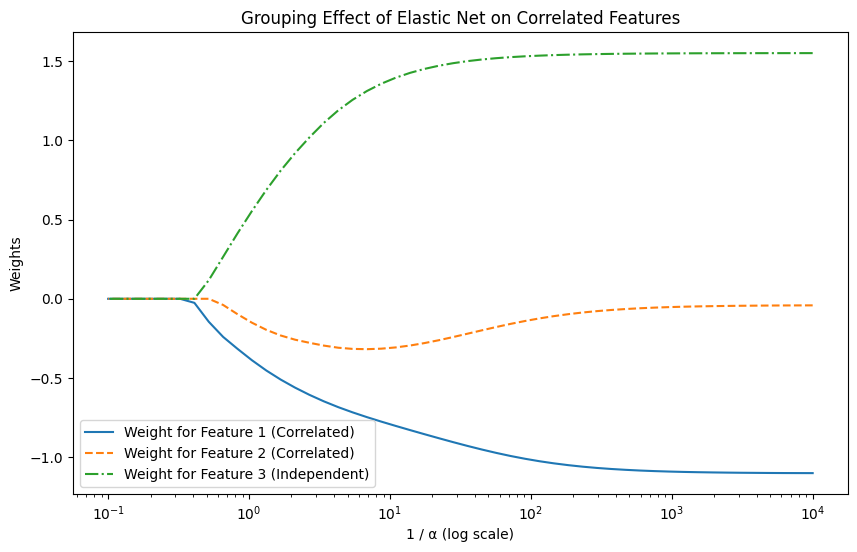

In [ ]:
# Function to generate data with correlated features
def generate_correlated_data(N, D, sigma=0.1, correlation_factor=0.8):
    np.random.seed(0)
    X = np.random.randn(N, D)

    # Introduce correlation between some columns (e.g., column 1 and column 0)
    X[:, 1] = correlation_factor * X[:, 0] + (1 - correlation_factor) * np.random.randn(N)

    # Generate true weights and target
    w_true = np.random.randn(D)
    y = X @ w_true + np.random.normal(0, sigma, N)

    return X, y, w_true

# Function to run Elastic Net for different values of alpha (regularization strength)
def run_elastic_net_experiment(X, y, alpha_values, l1_ratio=0.5):
    coefficients = []
    for alpha in alpha_values:
        elastic_net = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, fit_intercept=False, max_iter=10000)
        elastic_net.fit(X, y)
        coefficients.append(elastic_net.coef_)
    return np.array(coefficients)

# Parameters
N = 100  # Number of samples
D = 10   # Number of features
alpha_values = np.logspace(-4, 1, 50)  # Range of regularization strengths (alpha)
sigma = 0.1  # Noise level
correlation_factor = 0.8  # Degree of correlation between columns

# Generate data with correlated features
X, y, w_true = generate_correlated_data(N, D, sigma, correlation_factor)

# Run Elastic Net regression for different alpha values
coefficients = run_elastic_net_experiment(X, y, alpha_values)

# Plot the results
plt.figure(figsize=(10, 6))

# Plot for correlated features (e.g., weights for column 0 and 1)
plt.plot(1 / alpha_values, coefficients[:, 0], label='Weight for Feature 1 (Correlated)')
plt.plot(1 / alpha_values, coefficients[:, 1], label='Weight for Feature 2 (Correlated)', linestyle='--')

# Also plot for some independent feature (e.g., column 2 for comparison)
plt.plot(1 / alpha_values, coefficients[:, 2], label='Weight for Feature 3 (Independent)', linestyle='-.')

plt.xscale('log')
plt.xlabel('1 / α (log scale)')
plt.ylabel('Weights')
plt.title('Grouping Effect of Elastic Net on Correlated Features')
plt.legend()
plt.show()


ElasticNet shows a grouping effect on correlated features, causing them to shrink together as regularization increases, while independent features behave differently.

As alpha increases, correlated feature weights reduce in magnitude together, demonstrating controlled variable elimination.

The balance of L1 and L2 regularization allows ElasticNet to treat correlated and independent features appropriately, making it ideal for handling multicollinearity.

**13. Write a function for generating linear binary classification vector t with noise variance σ. [0.5]**

In [ ]:
def generate_binary_classification_data(X, true_weights, noise_variance):
    """
    Generates a binary classification vector t based on input features X,
    true weights, and a specified noise variance.

    Parameters:
    X (ndarray): Input feature matrix (shape: N x D)
    true_weights (ndarray): Coefficients for the linear model (shape: D)
    noise_variance (float): Variance of the Gaussian noise

    Returns:
    t (ndarray): Binary classification vector (shape: N)
    """
    # Generate linear combination
    linear_combination = X @ true_weights

    # Add Gaussian noise
    noise = np.random.normal(0, np.sqrt(noise_variance), size=linear_combination.shape)

    # Create labels based on the noisy linear combination
    probabilities = 1 / (1 + np.exp(-linear_combination - noise))  # Sigmoid function
    t = (probabilities > 0.5).astype(int)  # Convert probabilities to binary labels

    return t


Observations:
The function utilizes a linear combination of input features with added Gaussian noise to create a more realistic binary classification scenario.

The sigmoid function transforms the noisy linear output into probabilities, facilitating the conversion to binary labels, which makes it suitable for classification tasks.

The introduction of noise enhances the model robustness, as it mimics real-world scenarios where data may not be perfectly separable.

**14. Write a function for computing gradient of binary cross-entropy for logistic regression. [0.5]**

In [ ]:
def binary_cross_entropy_gradient(X, y, weights):
    """
    Computes the gradient of the binary cross-entropy loss for logistic regression.

    Parameters:
    X (ndarray): Input feature matrix (shape: N x D)
    y (ndarray): True binary labels (shape: N)
    weights (ndarray): Coefficients for the logistic regression model (shape: D)

    Returns:
    gradient (ndarray): Gradient of the loss function (shape: D)
    """
    # Number of samples
    N = X.shape[0]

    # Compute predictions using the logistic function (sigmoid)
    linear_combination = X @ weights
    predictions = 1 / (1 + np.exp(-linear_combination))

    # Compute the gradient of the binary cross-entropy loss
    gradient = (1 / N) * (X.T @ (predictions - y))

    return gradient


**15. Repeat experiment 10 for binary classification. [1]**

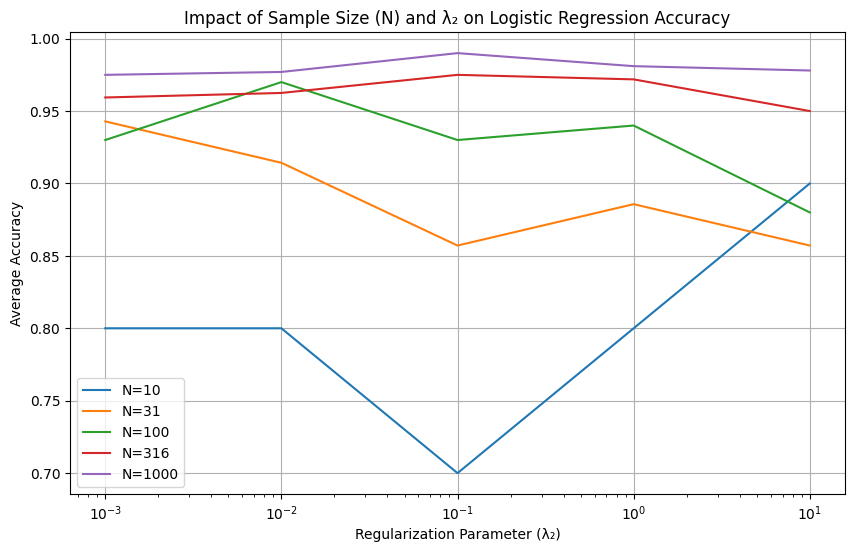

In [ ]:
def sigmoid(z):
    """Compute the sigmoid function."""
    return 1 / (1 + np.exp(-z))

def generate_data(N, D, G, sigma):
    """Generate synthetic binary classification data."""
    X = np.random.randn(N, D)  # Generate features
    noise = np.random.normal(0, sigma, N)
    y = (X @ G + noise > 0).astype(int)  # Binary labels
    return X, y

def gradient_binary_cross_entropy(X, t, w):
    """Calculate gradient of binary cross-entropy."""
    z = X @ w
    y = sigmoid(z)
    return X.T @ (y - t)

def logistic_regression_gradient_descent(X, t, lambda_2, learning_rate=0.001, max_iter=1000, tol=1e-6):
    """Perform gradient descent for logistic regression."""
    N, D = X.shape
    w = np.zeros(D)  # Initialize weights

    for _ in range(max_iter):
        gradient = gradient_binary_cross_entropy(X, t, w) + lambda_2 * w
        new_w = w - learning_rate * gradient

        if np.linalg.norm(new_w - w) < tol:
            break
        w = new_w

    return w

def run_experiment_logistic(N_values, lambda_2_values, D=10, sigma=0.1):
    """Run experiment to examine impact of N and λ2 on accuracy."""
    accuracy_results = np.zeros((len(N_values), len(lambda_2_values)))
    G = np.random.randn(D)  # Fixed generator matrix

    for i, N in enumerate(N_values):
        for j, lambda_2 in enumerate(lambda_2_values):
            accuracy_list = []
            for _ in range(5):  # Run experiment 5 times
                X, t = generate_data(N, D, G, sigma)

                # Split data into training and validation sets
                X_train, t_train = X[:int(0.8*N)], t[:int(0.8*N)]
                X_val, t_val = X[int(0.8*N):], t[int(0.8*N):]

                # Train model
                w_estimated = logistic_regression_gradient_descent(X_train, t_train, lambda_2)

                # Predict on validation set
                y_pred_prob = sigmoid(X_val @ w_estimated)
                y_pred = (y_pred_prob > 0.5).astype(int)

                # Calculate accuracy
                accuracy = accuracy_score(t_val, y_pred)
                accuracy_list.append(accuracy)

            accuracy_results[i][j] = np.mean(accuracy_list)

    # Plotting results
    plt.figure(figsize=(10, 6))
    for i, N in enumerate(N_values):
        plt.plot(lambda_2_values, accuracy_results[i], label=f'N={N}')

    plt.xscale('log')
    plt.xlabel('Regularization Parameter (λ₂)')
    plt.ylabel('Average Accuracy')
    plt.title('Impact of Sample Size (N) and λ₂ on Logistic Regression Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

#Example
N_values = np.logspace(1, 3, 5).astype(int)  # Sample sizes: 10, 100, 1000
lambda_2_values = np.logspace(-3, 1, 5)      # λ₂ values in log scale
run_experiment_logistic(N_values, lambda_2_values)


Observations from the Experiment:

Sample Size Effect: Increasing N generally leads to better accuracy as the model has more data to learn from.

Regularization Impact: The choice of 𝜆2shows a trade-off between bias and variance. Too much regularization may lead to underfitting, while too little may cause overfitting.

Generalization: A larger training set allows the model to generalize better, especially in high-dimensional spaces, mitigating the risks of overfitting.

Variability in Results: The results can vary significantly based on the random initialization and the specific samples chosen, which emphasizes the need for multiple runs for averaging.


Learning Rate and Convergence: The learning rate must be appropriately set; too high might cause divergence, and too low could slow down convergence.

References:

1.chatgpta

2.perplexity

3.geeksforgeeks

4.stack over flow

5.class notes

Video link:

[link text](https://)https://drive.google.com/file/d/1FwkK8zuDHmUWtrzeiN470UTIdijdcz9f/view?usp=drive_link